In [19]:
import requests
import datetime

import pandas as pd
import numpy as np
import zipfile

import mlflow
import os
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xg 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [3]:
#set up tracking server
TRACKING_SERVER_HOST = "34.171.118.161" #external IP reserved in GCP - updated aug 8 2024
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [4]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://34.171.118.161:5000'


In [5]:
data_file = "../data/processed/202304-usage.parquet"

In [6]:
mlflow.set_experiment("experiment-6")

2024/08/08 10:28:49 INFO mlflow.tracking.fluent: Experiment with name 'experiment-6' does not exist. Creating a new experiment.


<Experiment: artifact_location='gs://mlops-divvy-experiment-tracking/mlruns/6', creation_time=1723130929596, experiment_id='6', last_update_time=1723130929596, lifecycle_stage='active', name='experiment-6', tags={}>

In [ ]:
#keep these for hyperparameter tuning after setting up mlflow and prefect.

In [ ]:
# search_space = {
#     'max_depth': hp.choice("max_depth", np.arange(1,20,1,dtype=int)),
#     'eta'      : hp.uniform("eta", 0, 1),
#     'gamma'    : hp.uniform("gamma", 0, 10e1),
#     'reg_alpha': hp.uniform("reg_alpha", 10e-7, 10),
#     'reg_lambda' : hp.uniform("reg_lambda", 0,1),
#     'colsample_bytree': hp.uniform("colsample_bytree", 0.5,1),
#     'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1), 
#     'colsample_bylevel': hp.uniform("colsample_bylevel", 0.5,1),
#     'n_estimators': hp.choice("n_estimators", np.arange(100,1000,10,dtype='int')),
#     'min_child_weight' : hp.choice("min_child_weight", np.arange(1,10,1,dtype='int')),
#     'max_delta_step' : hp.choice("max_delta_step", np.arange(1,10,1,dtype='int')),
#     'subsample' : hp.uniform("subsample",0.5,1),
#     'objective' : 'binary:logistic',
#     'eval_metric' : 'aucpr',
#     'seed' : 44
# }

In [ ]:
# def xgb_objective(space):
#   results = xg.cv(space, 
#                    dtrain=dtrain_clf, #DMatrix (xgboost specific)
#                    num_boost_round=10, 
#                    nfold=5, 
#                    stratified=True,  
#                    early_stopping_rounds=5,
#                    metrics = ['logloss','auc','aucpr','error'])
  
#   best_score = results['test-auc-mean'].max()
#   return {'loss':-best_score, 'status': STATUS_OK}

In [11]:
with mlflow.start_run():
    #load prepared data
    df = pd.read_parquet(data_file)
    mlflow.log_param("data_file", data_file)

    cat_features = ['station_name', 'day_of_week']
    ohe = OneHotEncoder(handle_unknown='ignore')

    ohe_cols = pd.DataFrame(ohe.fit_transform(df[cat_features]).toarray(), columns = ohe.get_feature_names_out(cat_features))

    ohe_cols.index = df.index
    encoded_df = pd.concat([df, ohe_cols], axis=1)
    encoded_df = encoded_df.drop(cat_features, axis=1)

    with open("models/encoder-experiment6.pkl", "wb") as f:
        pickle.dump(ohe, f)
    mlflow.log_artifact("models/encoder-experiment6.pkl")

    #data split
    features = encoded_df.drop(['net_usage'], axis =1)
    target = encoded_df['net_usage']

    split_params = {"test_size": 0.2, "random_state": 42}
    X_train, X_test, y_train, y_test = train_test_split(features, target, **split_params)

    #scale numerical
    num_features= ['hour']
    Standard_Scaler = StandardScaler()
    num_scaled_train = pd.DataFrame(Standard_Scaler.fit_transform(X_train[num_features]), columns=['hour_scaled'])
    num_scaled_test = pd.DataFrame(Standard_Scaler.transform(X_test[num_features]), columns=['hour_scaled'])

    num_scaled_train.index = X_train.index
    num_scaled_test.index = X_test.index

    transformed_X_train = pd.concat([num_scaled_train, X_train], axis=1)
    transformed_X_test = pd.concat([num_scaled_test, X_test], axis=1)

    transformed_X_train = transformed_X_train.drop(num_features, axis=1)
    transformed_X_test = transformed_X_test.drop(num_features, axis=1)

    with open("models/scaler-experiment6.pkl", "wb") as f:
        pickle.dump(Standard_Scaler, f)
 

    #scale and ohe artifact for mlflow
    mlflow.log_artifact("models/scaler-experiment6.pkl")
    
    with open('../data/test_data/202304-usage-experiment6.pkl', 'wb') as f:
        pickle.dump((transformed_X_train, y_train, transformed_X_test, y_test), f)

    transformed_test = pd.concat([transformed_X_test, y_test], axis =1)
    transformed_test.to_parquet("../deployment/data/202304-test-transformed-experiment6.parquet")
    
    mlflow.log_param("transformed_test", transformed_test)

    #params = {"n_estimators": 10, "random_state": 42}
    #mlflow.log_params(params)

    xgbt = xg.XGBRegressor().fit(transformed_X_train, y_train) #**params
    
    y_pred = xgbt.predict(transformed_X_test)
    mlflow.log_metric("mse", mean_squared_error(y_test, y_pred))

    mlflow.sklearn.log_model(xgbt, artifact_path="models")
    print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

mlflow.search_experiments()

default artifacts URI: 'gs://mlops-divvy-experiment-tracking/mlruns/6/ac4d23bc09ec489b8f2bfa5b45d2ca82/artifacts'


[<Experiment: artifact_location='gs://mlops-divvy-experiment-tracking/mlruns/6', creation_time=1723130929596, experiment_id='6', last_update_time=1723130929596, lifecycle_stage='active', name='experiment-6', tags={}>,
 <Experiment: artifact_location='gs://mlops-divvy-experiment-tracking/mlruns/5', creation_time=1722263263295, experiment_id='5', last_update_time=1722263263295, lifecycle_stage='active', name='experiment-5', tags={}>,
 <Experiment: artifact_location='gs://mlops-divvy-experiment-tracking/mlruns/4', creation_time=1721847166117, experiment_id='4', last_update_time=1721847166117, lifecycle_stage='active', name='experiment-4', tags={}>,
 <Experiment: artifact_location='gs://mlops-divvy-experiment-tracking/mlruns/3', creation_time=1721846912312, experiment_id='3', last_update_time=1721846912312, lifecycle_stage='active', name='experiment-3', tags={}>,
 <Experiment: artifact_location='gs://mlops-divvy-experiment-tracking/mlruns/2', creation_time=1721227750156, experiment_id='2',

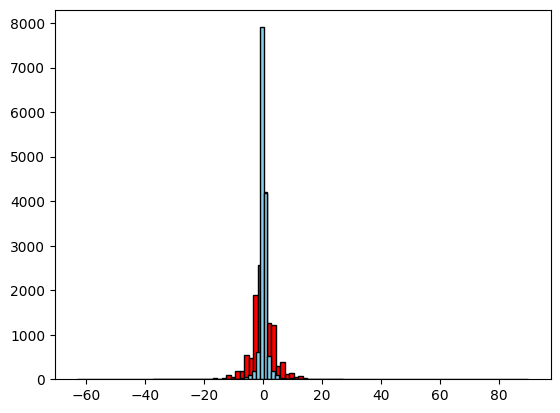

In [18]:
import matplotlib.pyplot as plt
plt.hist(y_test, bins=100, color='red', edgecolor='black')
plt.hist(y_pred, bins=50, color='skyblue', edgecolor='black')

plt.show()